In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
from itertools import cycle, islice
from lib.nyt_connections import get_connections_games
from lib.tasks import get_task_results, Task, TaskResult
import openai
from openai.types.chat.chat_completion import Choice
import os
from transformers import AutoTokenizer
from typing import cast, Iterable


games = get_connections_games()
games

[ConnectionsGame(board={'WET WEATHER': ConnectionsGroup(level=0, members=['HAIL', 'RAIN', 'SLEET', 'SNOW']), 'NBA TEAMS': ConnectionsGroup(level=1, members=['BUCKS', 'HEAT', 'JAZZ', 'NETS']), 'KEYBOARD KEYS': ConnectionsGroup(level=2, members=['OPTION', 'RETURN', 'SHIFT', 'TAB']), 'PALINDROMES': ConnectionsGroup(level=3, members=['KAYAK', 'LEVEL', 'MOM', 'RACECAR'])}, starting_board=[['SNOW', 'LEVEL', 'SHIFT', 'KAYAK'], ['HEAT', 'TAB', 'BUCKS', 'RETURN'], ['JAZZ', 'HAIL', 'OPTION', 'RAIN'], ['SLEET', 'RACECAR', 'MOM', 'NETS']], created_at=datetime.datetime(2023, 6, 12, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')), id=1, name='Connections #1'),
 ConnectionsGame(board={'FOOTWEAR': ConnectionsGroup(level=0, members=['BOOT', 'LOAFER', 'PUMP', 'SNEAKER']), 'UNITS OF LENGTH': ConnectionsGroup(level=1, members=['FOOT', 'LEAGUE', 'MILE', 'YARD']), 'MAGAZINES': ConnectionsGroup(level=2, members=['ESSENCE', 'PEOPLE', 'TIME', 'US']), 'LETTER HOMOPHONES': ConnectionsGroup(level=3, members=['ARE', 'Q

In [4]:
prompts = [
    "Find groups of four items that share something in common. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
    "Group words that share a common thread. There are four words for each common thread. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
    "This is a puzzle. Create four groups of four. Words in each group fit under a specific category. Some categories might be defined by their use of wordplay (palindromes, homophones, adding or dropping letters and words) rather than the literal meanings of the words on the cards. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
]


def get_tasks() -> Iterable[Task]:
    for game, (prompt, lowercase) in zip(
        cycle(games),
        cycle((prompt, lowercase) for prompt in prompts for lowercase in [True, False]),
    ):

        def grader(choice: Choice, game=game) -> float:
            assistant_content = choice.message.content
            assert assistant_content is not None
            assistant_content = assistant_content.strip()
            groups = [
                frozenset(word.strip().upper() for word in line.split(","))
                for line in assistant_content.split("\n")[-len(game.board) :]
            ]
            reward = 0
            for _, group_contents in game.board.items():
                if set(group_contents.members) in groups:
                    reward += 1 / len(game.board)
            return reward

        yield Task(
            messages=[
                {
                    "role": "user",
                    "content": f"{prompt}\nWords:\n\n{"\n".join(word.lower() if lowercase else word for row in game.starting_board for word in row)}",
                }
            ],
            grader=grader,
        )


tasks = list(islice(get_tasks(), len(games) * 2))
# distill_tasks = tasks[:436]
distill_tasks = tasks[:100]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

(100, 72, 92, 436)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-7B")
tokenizer

LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', vocab_size=151643, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<｜User｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151645: AddedToken("<｜Assistant｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151646: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151647: AddedToken("<|EOT|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151648: AddedToken("<think>", rstrip=False, 

In [ ]:
# AutoTokenizer.from_pretrained(
#     "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
# ).get_chat_template() == AutoTokenizer.from_pretrained(
#     "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B"
# ).get_chat_template() == AutoTokenizer.from_pretrained(
#     "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"
# ).get_chat_template() == AutoTokenizer.from_pretrained(
#     "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# ).get_chat_template()

True

In [ ]:
# AutoTokenizer.from_pretrained(
#     "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# ).get_chat_template()

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

"{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% set ns = namespace(is_first=false, is_tool=false, is_output_first=true, system_prompt='') %}{%- for message in messages %}{%- if message['role'] == 'system' %}{% set ns.system_prompt = message['content'] %}{%- endif %}{%- endfor %}{{bos_token}}{{ns.system_prompt}}{%- for message in messages %}{%- if message['role'] == 'user' %}{%- set ns.is_tool = false -%}{{'<｜User｜>' + message['content']}}{%- endif %}{%- if message['role'] == 'assistant' and message['content'] is none %}{%- set ns.is_tool = false -%}{%- for tool in message['tool_calls']%}{%- if not ns.is_first %}{{'<｜Assistant｜><｜tool▁calls▁begin｜><｜tool▁call▁begin｜>' + tool['type'] + '<｜tool▁sep｜>' + tool['function']['name'] + '\\n' + '```json' + '\\n' + tool['function']['arguments'] + '\\n' + '```' + '<｜tool▁call▁end｜>'}}{%- set ns.is_first = true -%}{%- else %}{{'\\n' + '<｜tool▁call▁begin｜>' + tool['type'] + '<｜tool▁sep｜>' + tool['fu

In [6]:
from dataclasses import dataclass
from openai.types.chat.chat_completion_token_logprob import ChatCompletionTokenLogprob

distill_client = openai.AsyncOpenAI(
    base_url="https://api.fireworks.ai/inference/v1",
    api_key=os.getenv("FIREWORKS_API_KEY"),
)
distill_model = "accounts/fireworks/models/deepseek-r1"


@dataclass
class TokenizedResult:
    conversation: list
    chat_template: str
    chat: str
    tokens: list[str]
    token_ids: list[int]
    assistant_mask: list[int]
    token_logprobs: list[ChatCompletionTokenLogprob] | None


def tokenize(task_result: TaskResult) -> TokenizedResult:
    conversation: list = task_result.task.messages + [
        {
            "role": "assistant",
            "content": task_result.chat_completion.choices[0].message.content,
        }
    ]
    assert isinstance(tokenizer.chat_template, str)
    chat_template = (
        tokenizer.get_chat_template()
        # Remove template logic that strips reasoning content from the chat messages
        .replace(
            "{% if '</think>' in content %}{% set content = content.split('</think>')[-1] %}{% endif %}",
            "",
        )
        # Add generation tags for assistant token masking
        .replace(
            "{{'<｜Assistant｜>' + content + '<｜end▁of▁sentence｜>'}}",
            "{{'<｜Assistant｜>'}}{% generation %}{{ content }}{% endgeneration %}{{'<｜end▁of▁sentence｜>'}}",
        )
    )
    chat = cast(
        str,
        tokenizer.apply_chat_template(
            conversation, chat_template=chat_template, tokenize=False
        ),
    )
    tokenized_result = cast(
        dict[str, list[int]],
        tokenizer.apply_chat_template(
            conversation,
            chat_template=chat_template,
            return_dict=True,
            return_assistant_tokens_mask=True,
        ),
    )
    tokens = [tokenizer.decode(token_id) for token_id in tokenized_result["input_ids"]]
    assistant_tokens = [
        token
        for token, mask in zip(tokens, tokenized_result["assistant_masks"])
        if mask
    ]
    if (
        task_result.chat_completion.choices[0].logprobs
        and task_result.chat_completion.choices[0].logprobs.content
    ):
        result_token_logprobs = task_result.chat_completion.choices[
            0
        ].logprobs.content.copy()
        if "".join(assistant_tokens) != "".join(
            token_logprob.token for token_logprob in result_token_logprobs
        ):
            print("Assistant tokens are not equal, skipping token logprobs")
            token_logprobs = None
        elif assistant_tokens == [
            token_logprob.token for token_logprob in result_token_logprobs
        ]:
            token_logprobs = result_token_logprobs
        else:
            completion = ""
            result_completion = ""
            token_logprobs = []
            try:
                while True:
                    if completion == result_completion:
                        token = assistant_tokens.pop(0)
                        result_token_logprob = result_token_logprobs.pop(0)
                        result_token = result_token_logprob.token
                        if token == result_token:
                            token_logprobs.append(result_token_logprob)
                        else:
                            token_logprobs.append(
                                ChatCompletionTokenLogprob(
                                    token=token,
                                    logprob=float("nan"),
                                    top_logprobs=[],
                                )
                            )
                        completion += token
                        result_completion += result_token
                    elif len(completion) < len(result_completion):
                        token = assistant_tokens.pop(0)
                        token_logprobs.append(
                            ChatCompletionTokenLogprob(
                                token=token,
                                logprob=float("nan"),
                                top_logprobs=[],
                            )
                        )
                        completion += token
                    elif len(completion) > len(result_completion):
                        result_completion += result_token_logprobs.pop(0).token
                    else:
                        print("Warning: Completions are not equal")
                        print(f"Completion: {completion}")
                        print(f"Result completion: {result_completion}")
                        token_logprobs = None
                        break
            except IndexError:
                pass
    else:
        token_logprobs = None
    return TokenizedResult(
        conversation=conversation,
        chat_template=chat_template,
        chat=chat,
        tokens=[
            tokenizer.decode(token_id) for token_id in tokenized_result["input_ids"]
        ],
        token_ids=tokenized_result["input_ids"],
        assistant_mask=tokenized_result["assistant_masks"],
        token_logprobs=token_logprobs,
    )


tokenized_results = await get_task_results(
    tasks=distill_tasks,
    client=distill_client,
    model=distill_model,
    transform=tokenize,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs


In [7]:
max(len(tokenized_result.token_ids) for tokenized_result in tokenized_results)

11534

In [8]:
sum(1 for tokenized_result in tokenized_results if tokenized_result.token_logprobs is None)

6

In [44]:
import torch

seq_len = 8192
token_ids = [[]]
group_ids = [[]]
assistant_mask = [[]]
logprobs = [[]]
advantages = [[]]

for result in tokenized_results:
    if len(result.token_ids) > seq_len:
        print("Result is too long, skipping")
        continue
    if len(token_ids[-1]) + len(result.token_ids) > seq_len:
        token_ids.append([])
        group_ids.append([])
        assistant_mask.append([])
        logprobs.append([])
        advantages.append([])
        group_id = 0
    else:
        group_id = max(group_ids[-1], default=-1) + 1
    token_ids[-1].extend(result.token_ids)
    group_ids[-1].extend([group_id] * len(result.token_ids))
    assistant_mask[-1].extend(result.assistant_mask)
    logprobs[-1].extend(
        [token_logprob.logprob for token_logprob in result.token_logprobs]
        if result.token_logprobs
        else [float("nan")] * len(result.token_ids)
    )
    advantages[-1].extend([0.0] * len(result.token_ids))


def pad(values: list[list], pad_value) -> list[list]:
    max_len = seq_len
    for value in values:
        value.extend([pad_value] * (max_len - len(value)))
    return values


token_ids = torch.tensor(pad(token_ids, tokenizer.pad_token_id))
group_ids = torch.tensor(pad(group_ids, -1))
assistant_mask = torch.tensor(pad(assistant_mask, 0))
logprobs = torch.tensor(pad(logprobs, float("nan")))
advantages = torch.tensor(pad(advantages, 0.0))
token_ids, group_ids, assistant_mask, logprobs, advantages

Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping


(tensor([[151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   2808,  ..., 151643, 151643, 151643],
         [151646, 151644,   1986,  ..., 151643, 151643, 151643],
         ...,
         [151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   2808,  ..., 151643, 151643, 151643],
         [151646, 151644,   2808,  ..., 151643, 151643, 151643]]),
 tensor([[ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         ...,
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1]]),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 tensor([[ 1.2000e-07, -2.1500e-06, -3.8774e-01,  ...,         nan,
                  nan,         nan],
 

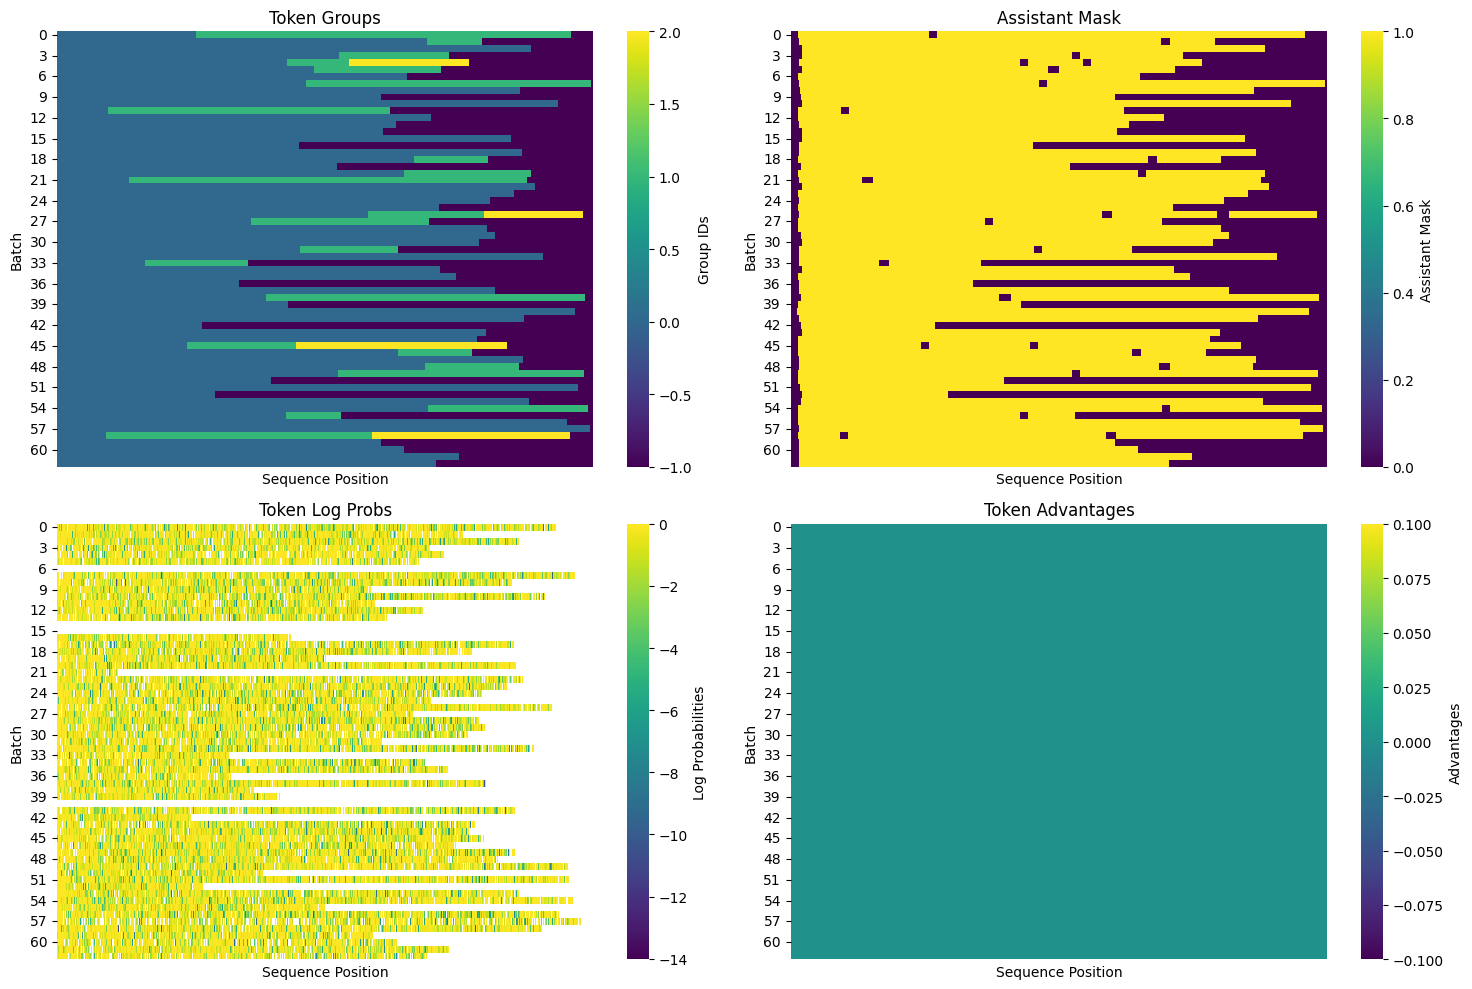

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_batch_tensor(
    tensor: torch.Tensor, label: str, title: str, subplot_idx: int
) -> None:
    plt.subplot(2, 2, subplot_idx)
    sns.heatmap(
        tensor.numpy(), cmap="viridis", cbar_kws={"label": label}, xticklabels=False
    )
    plt.title(title)
    plt.xlabel("Sequence Position")
    plt.ylabel("Batch")


plt.figure(figsize=(15, 10))
plot_batch_tensor(group_ids, "Group IDs", "Token Groups", 1)
plot_batch_tensor(assistant_mask, "Assistant Mask", "Assistant Mask", 2)
plot_batch_tensor(logprobs, "Log Probabilities", "Token Log Probs", 3)
plot_batch_tensor(
    advantages, "Advantages", "Token Advantages", 4
)  # Using logprobs as placeholder
plt.tight_layout()
plt.show()